# CÓDIGOS DE REFERÊNCIA (REMOVER ANTES DA VERSÃO FINAL)

## core.py

In [50]:
from typing import Callable, Optional, Sequence
import matplotlib.pyplot as plt

# Gostei muito da implementação dessas classes da lista 7 do professor então decidi implementar com pequenas modificações
class Domain:
    """
    Define o domínio no qual uma função real existe.
    """
    min = None
    max = None

    def __contains__(self, x):
        raise NotImplementedError
    
    def __repr__(self):
        raise NotImplementedError

    def __str__(self):
        return self.__repr__()
    
    def copy(self):
        raise NotImplementedError 


class Interval(Domain):
    """
    Define um intervalo de números reais.
    """
    def __init__(self, p1, p2):
        self.inff, self.supp = min(p1, p2), max(p1, p2)
    
    @property
    def min(self):
        return self.inff

    @property
    def max(self):
        return self.supp
    
    @property
    def size(self):
        return (self.max - self.min)
    
    @property
    def half(self):
        return (self.max + self.min)/2.0
    
    def __contains__(self, other):
        if isinstance(other, Interval):
            return other.min >= self.min and other.max <= self.max
        elif isinstance(other, (float, int)):
            return self.min <= other <= self.max
        elif isinstance(other, Sequence):
            for i in other:
                if not (self.min <= i <= self.max):
                    return False
            return True
        else:
            return False


    def __str__(self):
        return f'[{self.min:2.4f}, {self.max:2.4f}]' 

    def __repr__(self):
        return f'[{self.min!r:2.4f}, {self.max!r:2.4f}]'
    
    def copy(self):
        return Interval(self.min, self.max)

    def intersect(self, other: 'Interval') -> Optional['Interval']:
        if not isinstance(other, Interval):
            return None
        
        newMin = max(self.min, other.min)
        newMax = min(self.max, other.max)
        return Interval(newMin,newMax) if newMin <= newMax else None

class RealFunction:
    """
    Classe abstrata que deve ser utilizada para implementação de funções reais, e.g. Polinomios
    """

    f: Callable[[float], float]
    prime: Optional[Callable[[float], float]]
    domain: Optional[Interval]
    
    def eval_safe(self, x):
        if self.domain is None or x in self.domain:
            return self.f(x)
        else:
            raise Exception("The number is out of the domain")

    def prime_safe(self, x):
        if self.prime is None:
            raise NotImplementedError("Derivative function (prime) is not defined for this function.")
        if self.domain is None or x in self.domain:
            return self.prime(x)
        else:
            raise Exception("The number is out of the domain")
        
    def __call__(self, x) -> float:
        return self.eval_safe(x)
    
    def plot(self, intervalo: Optional[Interval] = None, pontos: int = 100) -> tuple[plt.Figure, plt.Axes]:
        """
        Plota o gráfico da função real no intervalo especificado. Caso nenhum intervalo seja fornecido,
        será utilizado o domínio da função. Se o domínio da função também for None,uma exceção será 
        levantada. O número de pontos no gráfico poder ser ajustado, sendo 100 o padrão.

        Args:
            intervalo (Optional[Interval], optional): Intervalo para plotagem. Default é None.
            pontos (int, optional): Número de pontos no gráfico. Default é 100.
        Returns:
            tuple[plt.Figure, plt.Axes]: Figura e eixos do gráfico plotado.
        Examples:
            >>> f = Polinomio([1, -3, 2], Interval(0, 5))  # Representa P(x) = x^2 - 3x + 2
            >>> fig, ax = f.plot(Interval(0, 5), pontos=200)
            >>> plt.show()
        """
        dominio = self.domain
        if intervalo is not None:
            dominio = intervalo
        if dominio is None:
            raise Exception("Domínio da função não está definido.")
        fig, ax = plt.subplots()
        X = linspace(dominio.min, dominio.max, pontos)
        Y = [self(val) for val in X]
        ax.plot(X,Y)
        return fig, ax
    
def linspace(min: float, max: float, points: int) -> list[float]:
    """
    Retorna uma lista de pontos igualmente distribuídos em um intervalo

    Args:
        min (float): Valor mínimo do intervalo de pontos
        max (float): Vamor máximo do intervalo de pontos
        points (int): Quantidade de pontos

    Returns:
        list[float]: Lista de pontos igualmente distribuídos no intervalo

    Examples:
        >>> valores = linspace(0, 5, 6)
        >>> print(valores)
        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
    """
    if points < 2:
        return [min]
    step = (max - min) / (points - 1)
    return [(step * i + min) for i in range(points)]

def safe_intersect(d1: Optional['Interval'], d2: Optional['Interval']) -> Optional['Interval']:
    """
    Calcula a intersecção de dois intervalos, lidando com valores None.
    """
    if d1 is None or d2 is None:
        return None

    return d1.intersect(d2)

## polinomios.py

None
[0.0]
([2.0], [0.0])
[2.0, 5.0, 4.0, 8.0, 5.0, -3.0, 2.0, 4000.0]
[14.0, 30.0, 20.0, 32.0, 15.0, -6.0, 2.0]
107.0
None
9.0


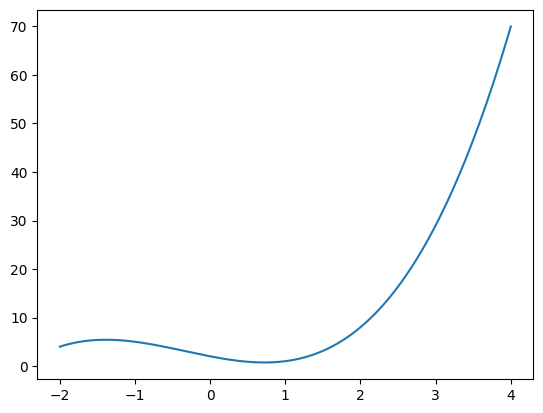

In [51]:
from typing import List, Tuple, Callable, Optional, cast
# Tentar executar localmente a partir da pasta geral do repositório vai dar erro, mas é assim mesmo que deve estar para o deploy.
# Se quiser testar localmente use o comando 'python -m CB2325NumericaG6.polinomios' sem as aspas.
# from .core import RealFunction, Interval, Domain, safe_intersect # CONSERTAR ERRO!!!!
from sys import float_info

class Polinomio(RealFunction):
    """
    Representa um polinômio como uma lista de coeficientes, ordenados 
    do termo de **maior grau** para o termo constante.

    P[0] é o coeficiente do maior grau, e o grau é dado por len(P) - 1.
    Exemplo: O polinômio P(x) = 3x^2 + 2x - 1 é representado por [3.0, 2.0, -1.0].
    """

    # Importa o epsilon de maquina do sistema
    BASE_TOLERANCE = float_info.epsilon 

    def __init__(self, values: List[float], domain: Optional[Interval] = None):
        maxAbsCoeff = max((abs(v) for v in values), default=1.0)
        
        # Calcula a tolerância relativa para o polinomio
        self.TOLERANCE = self.BASE_TOLERANCE * maxAbsCoeff

        if self.TOLERANCE == 0.0:
            self.TOLERANCE = self.BASE_TOLERANCE

        self._values = [
            float(v) if abs(v) >= self.TOLERANCE else 0.0
            for v in values
        ]

        if self._values and abs(self._values[0]) < self.TOLERANCE:
            self._clearZeros()

        self.f = lambda x: self.evaluate(x)
        self.domain = domain
        self._primeFunc = None

    def __call__(self, x) -> float:
        return super().__call__(x)
    
    def __repr__(self):
        return str(self._values)
    
    def __len__(self):
        return len(self._values)
    
    def __getitem__(self, index: int):
        size = len(self._values)
        if abs(index) >= size:
            raise IndexError("index out of range")
        elif index < 0:
            return self._values[size + index]
        else:
            return self._values[index]

    def __setitem__(self, index: int, value: float):
        size = len(self._values)
        if abs(index) >= size:
            raise IndexError("assignment index out of range")
        elif index < 0:
            self._values[size + index] = value
        else:
            self._values[index] = value

    def _clearZeros(self):
        """
        Função interna para remover os 0s dos líderes
        """
        count = 0
        for coef in self._values:
            if coef == 0.0:
                count += 1
            else:
                break
        
        if count == len(self._values):
            self._values = []
        elif count> 0:
            self._values = self._values[count:]
        
        if not self._values:
            self._values.append(0.0)

    @property
    def degree(self) -> int:
        return len(self._values)-1
    
    @property
    def isZero(self) -> bool:
        return self._values == [0.0]
    
    @property
    def prime(self): # type: ignore
        if self._primeFunc is None:
            polinomio_derivado = self.diff()
            self._primeFunc = lambda x: polinomio_derivado.evaluate(x) 
        return self._primeFunc
    
    def evaluate(self, x: float) -> float:
        """
            Avalia o polinômio P(x) para um dado valor de x usando o Método de Horner.
            
            P é uma lista de coeficientes em ordem decrescente: [c_n, ..., c_0].
            
            Args:
                x (float): O ponto onde o polinômio será avaliado.
                
            Returns:
                float: O valor P(x).
            
            Examples:
                >>> P = Polinomio([2,3,4])
                >>> val = P.evaluate(1)
                >>> print(val)
                9

        """
        if not self._values:
            return 0.0

        resultado = self._values[0] 
        
        for i in range(1, len(self._values)):
            resultado = resultado * x + self._values[i]
            
        return resultado
    
    def __mul__(self, other: float | int) -> 'Polinomio':
        newValues = [c * float(other) for c in self._values]
        return Polinomio(newValues, self.domain)

    def __rmul__(self, other: float | int) -> 'Polinomio':
        return self.__mul__(other)
    
    def __neg__(self) -> 'Polinomio':
        new_values = [-c for c in self._values]
        return Polinomio(new_values, self.domain)
    
    def __add__(self, other: 'Polinomio') -> 'Polinomio':
        """Adição de polinômios: P1 + P2 (Começando pelo termo de maior grau)"""
        
        newDomain = safe_intersect(self.domain, other.domain)

        p1Coeffs = self._values
        p2Coeffs = other._values

        len1 = len(p1Coeffs)
        len2 = len(p2Coeffs)
        maxLen = max(len1, len2)
        
        newCoeffs = [0.0] * maxLen
        
        for i in range(maxLen):
            idx1 = len1 - 1 - i
            idx2 = len2 - 1 - i
            idx_res = maxLen - 1 - i
            
            c1 = p1Coeffs[idx1] if idx1 >= 0 else 0.0
            c2 = p2Coeffs[idx2] if idx2 >= 0 else 0.0
            
            newCoeffs[idx_res] = c1 + c2
            
        return Polinomio(newCoeffs, newDomain)
    
    def __sub__(self, other: 'Polinomio') -> 'Polinomio':
        negOther = -other 
        return self + negOther
    
    def __eq__(self, other) -> bool:
        #Assume que ambos não tem coeficiente líderes 0.
        if not isinstance(other, Polinomio):
            return NotImplemented
        return other._values == self._values

    def divideBy(self, divisor: 'Polinomio') -> Tuple['Polinomio', 'Polinomio']:
        """
            Realiza a divisão polinomial A / B (self / divisor) e retorna (Quociente, remainder).

            Args:
                divisor (Polinomio): Polinomio divisor
                tolerance (float, optional): Tolerância para checagem de zero, usado para
                    tratar erros de ponto flutuante. O valor padrão é 1e-12.

            Returns:
                Polinomio: Polinomio derivado

            Examples:
                >>> p1 = Polinomio([4,6,8])
                >>> p2 = Polinomio([2,3,4])
                >>> print(p1.divideBy(p2))
                ([2.0], [0.0])
        """

        if divisor.degree < 0 or abs(divisor._values[0]) < self.TOLERANCE:
            raise ValueError("Cannot divide by the zero polynomial.")

        newDomain = safe_intersect(self.domain, divisor.domain)

        if self.degree < divisor.degree:
            return Polinomio([0.0], newDomain), Polinomio(self._values, newDomain)
        
        if divisor.degree == 0:
            constante_divisor = divisor._values[0]
            qCoeffs = [c / constante_divisor for c in self._values]
            return Polinomio(qCoeffs, newDomain), Polinomio([0.0], newDomain)

        mainDivisor = divisor._values[0]
        divisorDegree = divisor.degree
        
        quotientCoeffs = [0.0] * (self.degree - divisorDegree + 1)

        remainder = Polinomio(self._values) 
        
        while remainder.degree >= divisorDegree:
            mainRemainder = remainder._values[0]
            
            degreeDifference = remainder.degree - divisorDegree
            
            qCoeff = mainRemainder / mainDivisor

            qIdx = self.degree - remainder.degree
            quotientCoeffs[qIdx] = qCoeff
    
            multipliedTherm = divisor * qCoeff 

            shiftCoeffs = multipliedTherm._values + [0.0] * degreeDifference
            thermToSub = Polinomio(shiftCoeffs)

            remainder = remainder - thermToSub 

        if remainder.degree < 0:
            remainder = Polinomio([0.0], newDomain)

        return Polinomio(quotientCoeffs, newDomain), remainder
    
    def _getPNeg(self) -> 'Polinomio':
        """
        Cria e retorna o polinômio auxiliar P(-x).
        Isso inverte o sinal dos coeficientes dos termos de grau ímpar.
        """
        PNegCoeffs = []
        
        for i, coeff in enumerate(self._values):
            degree = self.degree - i

            if degree % 2 != 0:
                PNegCoeffs.append(-coeff)
            else:
                PNegCoeffs.append(coeff)
                
        return Polinomio(PNegCoeffs, self.domain)
    
    def getRealRootBounds(self) -> tuple[float, float]:
        """
            Calcula os limites superior positivo (L) e inferior negativo (l) 
            para todas as raízes reais do polinômio P(x)
            (Teorema dos Limites para Raízes de Polinômios (Cauchy Bound)).
        """
        if self.degree == 0:
            return 0.0, 0.0
        
        cn = self._values[0]
        cMax = max(abs(c) for c in self._values[1:]) if self.degree > 0 else 0.0
            
        if cMax == 0.0:
            L = 0.0
        else:
            L = 1.0 + (cMax / abs(cn))

        pNeg = self._getPNeg() 
        
        cnNeg = pNeg._values[0]
        cMaxNeg = max(abs(c) for c in pNeg._values[1:]) if pNeg.degree > 0 else 0.0
        
        if cMaxNeg == 0.0:
            Lneg = 0.0
        else:
            Lneg = 1.0 + (cMaxNeg / abs(cnNeg))

        l = -Lneg
        
        return l, L

    def diff(self) -> 'Polinomio':
        """
            Retorna a derivada de um polinomio.

            Returns:
                Polinomio: Polinomio derivado

            Examples:
                >>> pol = Polinomio([-3.0,2.0,4.0])
                >>> dPol = pol.diff()
                >>> print(dPol)
                [-6.0,2.0]
        """

        if len(self) <= 1:
            return Polinomio([0])
        
        derivative = []

        for i in range(self.degree):
            derivative.append(self[i]*(self.degree-i))

        return Polinomio(derivative, self.domain)

def lambdify(P: 'Polinomio') -> Callable[[float], float]:
    """
    Cria e retorna uma função lambda (Callable) que avalia o polinômio P(x).
    
    Isso permite que o objeto Polinomio seja usado em métodos que esperam 
    uma função f(x), como Bisseção ou Secante.
    
    Args:
        P (Polinomio): O objeto Polinomio a ser convertido.
        
    Returns:
        Callable[[float], float]: Uma função lambda que recebe x (float) 
                                  e retorna P(x) (float).
    """
    
    def func_wrapper(x: float) -> float:
        """Função interna que avalia o polinômio P em x."""
        return P.evaluate(x)
        
    return func_wrapper

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    #Deve ignorar o primeiro coeficiente pois para o epsilon de máquina ele é zero.
    pol = Polinomio([0.0000000000001, 2,5,4,8,5,-3.0,2.0,4000])
    p1 = Polinomio([4,6,8], Interval(1,4))
    p2 = Polinomio([2,3,4], Interval(5,6))

    p3 = p1.divideBy(p2)

    print(p3[0].domain)

    print(p2*2 - p1)
    print(p3)

    print(pol)
    dPol = pol.diff()
    print(dPol)
    print(pol.prime(1))
    print(dPol.domain)

    print(p2.evaluate(1))

    polinomio = Polinomio([1, 1, -3, 2], Interval(-6,6))  # Representa P(x) = x^2 - 3x + 2
    polinomio.plot(Interval(-2, 4), pontos=200)
    plt.show()

## interpolacao.py

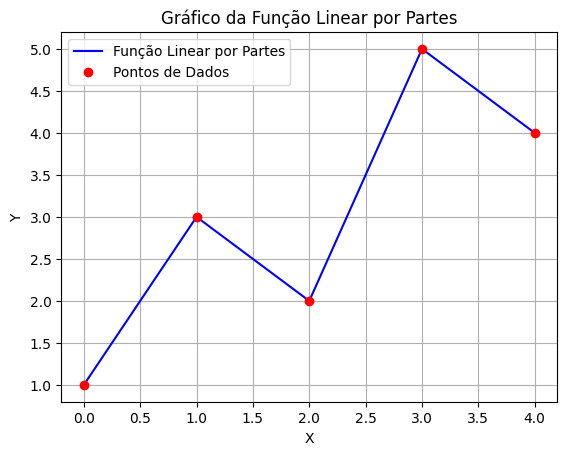

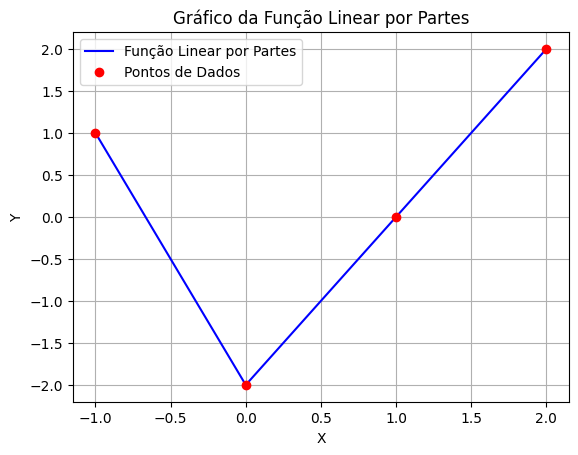

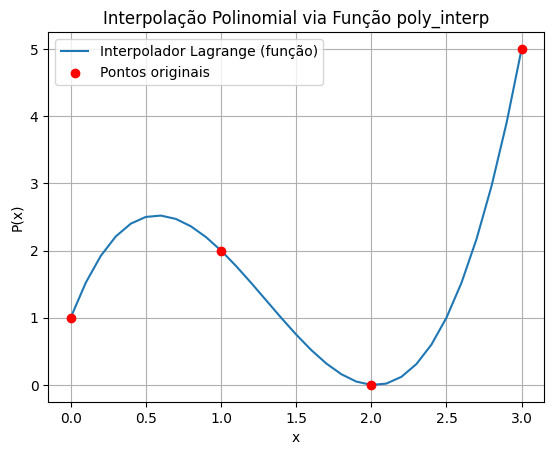

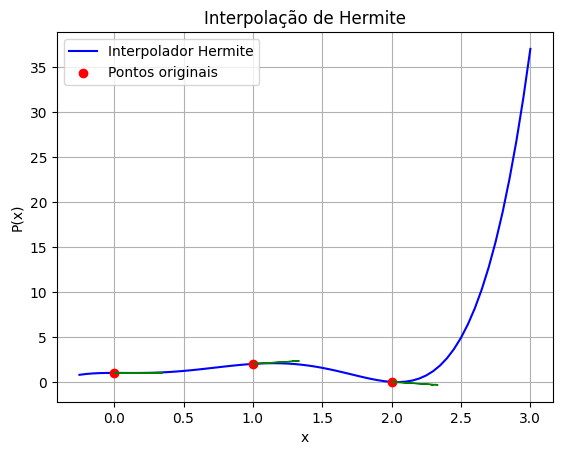

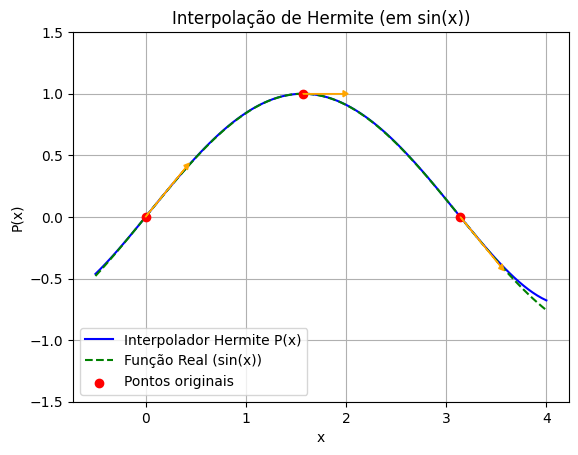

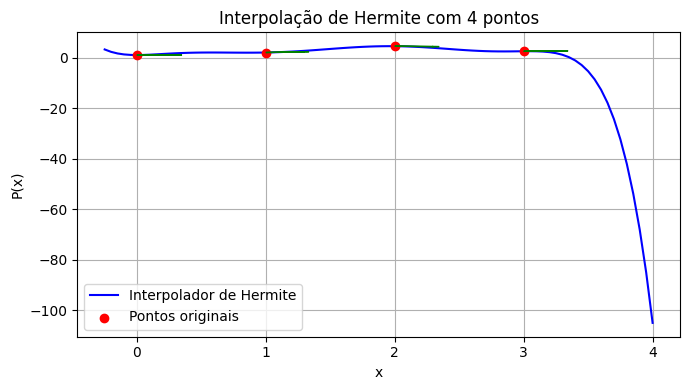

In [52]:
from typing import Callable, Sequence, Optional, List, Tuple
# from .core import RealFunction, Interval
# from .polinomios import Polinomio # CONSERTAR ERRO!!!!
import matplotlib.pyplot as plt

class HermiteInterpolation(RealFunction):
    def __init__(self, x: Sequence[float], y: Sequence[float], dy: Sequence[float], domain: Optional[Interval] = None):
        self.X = x
        self.Y = y
        self.DY = dy
        self.domain = domain 
        self.f = self._coeficientes() # O Callable principal para RealFunction

    def _coeficientes(self):
        if len(self.X) != len(self.Y) or len(self.X) != len(self.DY) or len(self.X) < 2:
            raise ValueError("x, y, dy devem ter mesmo tamanho e conter ao menos dois pontos.")

        n = len(self.X)
        coef = [0.0 for _ in range(2*n)]

        for i in range(n):
            Li = [1.0]
            denom = 1.0
            for j in range(n):
                if j != i:
                    novo = [0.0 for _ in range(len(Li)+1)]
                    for k in range(len(Li)):
                        novo[k] -= Li[k] * self.X[j]
                        novo[k+1] += Li[k]
                    Li = novo
                    denom *= (self.X[i] - self.X[j])
            Li = [a / denom for a in Li]

            Li_prime = sum(1 / (self.X[i] - self.X[m]) for m in range(n) if m != i)

            Li2 = [0.0]*(2*len(Li)-1)
            for p in range(len(Li)):
                for q in range(len(Li)):
                    Li2[p+q] += Li[p]*Li[q]

            Ki = [0.0]*(len(Li2)+1)
            for k in range(len(Li2)):
                Ki[k] -= Li2[k] * self.X[i]
                Ki[k+1] += Li2[k]

            Hi = [0.0]*(len(Li2)+1)
            for k in range(len(Li2)):
                Hi[k] += Li2[k]
            for k in range(len(Li2)):
                Hi[k] += 2*Li_prime*Li2[k]*self.X[i]  
                Hi[k+1] -= 2*Li_prime*Li2[k]           
            termo = [0.0]*max(len(Hi), len(Ki))
            for k in range(len(Hi)):
                termo[k] += self.Y[i]*Hi[k]
            for k in range(len(Ki)):
                termo[k] += self.DY[i]*Ki[k]

            for k in range(len(termo)):
                coef[k] += termo[k]

        while len(coef) > 1 and abs(coef[-1]) < 1e-14:
            coef.pop()

        return Polinomio(coef[::-1])
        
    def evaluate(self, v: float) -> float:
        if len(self.X) != len(self.Y) or len(self.X) < 2:
            raise ValueError(f"x and y must have the same length ({len(self.X)} != {len(self.Y)}) and have atleast 2 points.")
        return self.f.evaluate(v)




def hermite_interp(x: Sequence[float], y: Sequence[float], dy: Sequence[float], domain: Optional[Interval]=None) -> HermiteInterpolation:
    """
    Cria uma função de interpolação polinomial de Hermite a partir de um conjunto de coordenadas X, Y
    e de suas derivadas.

    Args:
        x (Sequence[float]): Coordenadas no eixo X.
        y (Sequence[float]): Valores de Y nas respectivas coordenadas.
        dy (Sequence[float]): Valores das derivadas nas respectivas coordenadas.
        domain (Optional[Interval]): domínio da função (opcional)
        
    Returns:
        HermiteInterpolation: Uma classe chamável que avalia o polinômio interpolador de Hermite.
        
    Raises:
        ValueError: Se x, y e dy tiverem comprimentos diferentes ou contiverem menos de dois pontos.
    """
    if len(x) != len(y) or len(x) != len(dy) or len(x) < 2:
        raise ValueError(
            f"x, y, dy must have the same length and contain at least two points "
        )

    return HermiteInterpolation(x, y, dy, domain)
 


class PolinomialInterpolation(RealFunction):
    def __init__(self, x: Sequence[float], y: Sequence[float], domain: Optional[Interval] = None):
        self.X = x
        self.Y = y
        self.domain = domain
        self.f = self._coeficientes() # O Callable principal para RealFunction

    def _coeficientes(self):
        n = len(self.X)
        coef = [0.0 for _ in range(n)]

        for i in range(n): 
            Li = [1.0]
            denom = 1.0

            for j in range(n): 
                if i != j:
                    novo = [0.0 for _ in range(len(Li) + 1)]
                    for k in range(len(Li)):
                        novo[k]     += Li[k]          
                        novo[k + 1] -= Li[k] * self.X[j]
                    Li = novo
                    denom *= (self.X[i] - self.X[j])

            Li = [a * (self.Y[i] / denom) for a in Li]
            for k in range(len(Li)):
                coef[k] += Li[k]

        return Polinomio(coef) 

    def evaluate(self, v: float) -> float:
        if len(self.X) != len(self.Y) or len(self.X) < 2:
            raise ValueError(f"x and y must have the same length ({len(self.X)} != {len(self.Y)}) and have atleast 2 points.")
        return self.f.evaluate(v)
    
    

 
def poly_interp(x: Sequence[float], y: Sequence[float], domain: Optional[Interval] = None) -> PolinomialInterpolation:
    """
    Cria uma função de interpolação polinomial a partir de um conjunto de coordenadas X e Y,
    utilizando a forma de Lagrange.

    Args:
        x (Sequence[float]): Sequência das coordenadas no eixo X.
        y (Sequence[float]): Sequência dos valores correspondentes no eixo Y.
        domain (Optional[Interval]): domínio da função (opcional)

    Returns:
        PolinomialInterpolation: Uma classe chamável que avalia o polinômio interpolador
        para qualquer valor de entrada do tipo float.

    Raises:
        ValueError: Se x e y tiverem comprimentos diferentes ou contiverem menos de dois pontos.
    """
    if len(x) != len(y) or len(x) < 2:
        raise ValueError(f"x and y must have the same length ({len(x)} != {len(y)}) and have atleast 2 points.")
    
    return PolinomialInterpolation(x, y, domain)




class PiecewiseLinearFunction(RealFunction):
    def __init__(self, x: Sequence[float], y: Sequence[float], domain: Optional[Interval] = None):
        self.X = x
        self.Y = y
        self.domain = domain if domain else Interval(min(x), max(x))
        self.f = self.evaluate # O Callable principal para RealFunction

    def makePolynomialSegment(self, x1, x2, y1, y2) -> Polinomio:
        if x1 == x2:
            raise ValueError("Pontos x1 e x2 são o mesmo. Não é possível criar um segmento.")

        slope = (y2-y1)/(x2-x1)
        c0 = y1 - slope * x1
        segmentDomain = Interval(min(x1, x2), max(x1, x2))

        pol = Polinomio([slope, c0], segmentDomain) 

        return pol

    @property
    def prime(self) -> Callable[[float], float]: #type: ignore
        """
        Retorna a função que calcula a derivada (inclinação constante) 
        da interpolação linear por partes. A derivada é indefinida nos pontos de referência.
        """
        
        # O self.prime da RealFunction é um Callable. Retornamos uma função que implementa a lógica da derivada.
        def piecewisePrimeFunction(v: float) -> float:
            if not (self.X[0] <= v <= self.X[-1]):
                raise ValueError(f"O ponto {v} está fora do domínio de interpolação.")
            
            n = len(self.X)
            
            for x_i in self.X:
                if abs(v - x_i) < 1e-12: 
                    raise ValueError(f"A derivada é descontínua e indefinida no nó x={v}.")

            start, end = 0, n - 1

            while end - start != 1:
                mid = (end + start) // 2
                if self.X[mid] > v:
                    end = mid
                else:
                    start = mid
            
            x1, x2 = self.X[start], self.X[end]
            y1, y2 = self.Y[start], self.Y[end]
            
            slope = (y2 - y1) / (x2 - x1)
            
            return slope

        return piecewisePrimeFunction

    def evaluate(self, v: float) -> float:
        n = len(self.X)
        if v > self.X[-1]:
            start, end = n - 2, n - 1
        elif v < self.X[0]:
            start, end = 0, 1
        elif v == self.X[0]:
            return self.Y[0]
        elif v == self.X[-1]:
            return self.Y[-1]
        else:
            start, end = 0, n - 1 
            while end - start != 1:
                mid = (end + start) // 2
                if self.X[mid] > v:
                    end = mid
                elif self.X[mid] < v:
                    start = mid
                else:
                    return self.Y[mid] 

        x1, x2 = self.X[start], self.X[end]
        y1, y2 = self.Y[start], self.Y[end]

        return y1 + (v - x1) * ((y2 - y1) / (x2 - x1))
    
    def find_root_segments(self) -> List[Tuple[float, float]]:
        """
        Retorna uma lista de intervalos [a, b] onde f(a) * f(b) < 0.
        """

        segments = []
        for i in range(len(self.X) - 1):
            y_i = self.Y[i]
            y_i_plus_1 = self.Y[i+1]
            
            # Se os sinais são opostos (garantia da raiz)
            if y_i * y_i_plus_1 < 0:
                segments.append((self.X[i], self.X[i+1]))
                
            if y_i == 0:
                segments.append((self.X[i], self.X[i]))

        if self.Y[-1] == 0:
            segments.append((self.X[-1], self.X[-1]))
            
        return segments

    def plot(self) -> tuple[plt.Figure, plt.Axes]:
        """
        Plota o gráfico da função linear por partes.
        Returns:
            tuple[plt.Figure, plt.Axes]: Figura e eixos do gráfico plotado.
        Examples:
            >>> x = [0, 2, 4, 5]
            >>> y = [1, 2, 0, 4]
            >>> p = linear_interp(x, y)
            >>> fig, ax = p.plot()
            >>> plt.show()
        """
        fig, ax = plt.subplots()
        # Plota as linhas que interligam os pontos
        ax.plot(self.X, self.Y, linestyle='-', color='blue', label='Função Linear por Partes')

        # Plota os pontos de dados individuais
        ax.plot(self.X, self.Y, 'o', color='red', label='Pontos de Dados') # 'o' para marcadores de círculo

        ax.set_title("Gráfico da Função Linear por Partes")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.grid(True)
        ax.legend() # Mostra a legenda dos elementos plotados

        return fig, ax
        
    
def linear_interp(x: Sequence, y: Sequence) -> PiecewiseLinearFunction:
    """Cria uma função de interpolação (e extrapolação)s linear a partir de um par de sequências de coordenadas X,Y
    assumindo que os valores X são estritamente crescentes.

    Args:
        x (Sequence): Lista de coordenadas do eixo X (estritamente crescente)
        y (Sequence): Lista de coordenadas do eixo Y
    
    Returns:
        Interpolator: Uma função que retorna o valor interpolado linearmente baseado nos valores X, Y.
    Raises:
        ValueError: Se a quantidade de elementos de X e Y forem diferentes ou tiverem menos de dois pontos.
    Examples:
        >>> x = [0, 2, 4, 5]
        >>> y = [1, 2, 0, 4]
        >>> p = linear_interp(x, y)
        >>> print(p(1.5))
        1.75
    """
    
    if len(x) != len(y):
        raise ValueError("Lenght of X is different of Y")
    if len(x) < 2:
        raise ValueError("There must be atleast 2 points")
    
    return PiecewiseLinearFunction(x, y)


if __name__ == "__main__":
    x = [0, 1, 2, 3, 4]
    y = [1, 3, 2, 5, 4]
    plf = linear_interp(x, y)
    fig, ax = plf.plot()
    plt.show()

    a = [-1, 0, 1, 2]
    b = [1, -2, 0, 2]
    plf2 = linear_interp(a, b)  
    fig2, ax2 = plf2.plot()
    plt.show()

    x_poly = [0, 1, 2, 3]
    y_poly = [1, 2, 0, 5]

    # Usando a função poly_interp
    P = poly_interp(x_poly, y_poly)
    X_plot = [i / 10 for i in range(0, 31)]  # domínio para visualização
    Y_plot = [P(x) for x in X_plot]


    plt.figure()
    plt.plot(X_plot, Y_plot, label="Interpolador Lagrange (função)")
    plt.scatter(x_poly, y_poly, color="red", zorder=5, label="Pontos originais")
    plt.title("Interpolação Polinomial via Função poly_interp")
    plt.xlabel("x")
    plt.ylabel("P(x)")
    plt.grid(True)
    plt.legend()
    plt.show()


    # --- Dados de exemplo ---
    x = [0.0, 1.0, 2.0]
    y = [1.0, 2.0, 0.0]
    dy = [0.0, 1.0, -1.0]

    # --- Cria interpolador de Hermite ---
    P = hermite_interp(x, y, dy)

    # --- Gera pontos para o gráfico ---
    X_plot = [i / 20 for i in range(-5, 61)]  # de -0.25 até 3.05
    Y_plot = [P.evaluate(X) for X in X_plot]

    # --- Plota ---
    plt.figure()
    plt.plot(X_plot, Y_plot, label="Interpolador Hermite", color="blue")
    plt.scatter(x, y, color="red", zorder=5, label="Pontos originais")

    # Desenha setinhas indicando derivadas (slopes)
    for xi, yi, dyi in zip(x, y, dy):
        plt.arrow(
            xi, yi, 0.3, 0.3 * dyi, 
            head_width=0.05, head_length=0.05,
            fc='green', ec='green', zorder=6
        )

    plt.title("Interpolação de Hermite")
    plt.xlabel("x")
    plt.ylabel("P(x)")
    plt.grid(True)
    plt.legend()
    plt.show()

    import numpy as np

    # --- Dados de entrada baseados em f(x) = sin(x) ---
    x = [0.0, np.pi/2, np.pi]
    y = [np.sin(xi) for xi in x]  # [0.0, 1.0, 0.0]
    dy = [np.cos(xi) for xi in x] # [1.0, 0.0, -1.0]

    # --- Cria interpolador de Hermite ---
    P = HermiteInterpolation(x, y, dy)

    # --- Gera pontos para o gráfico ---
    # Vamos plotar de -0.5 a 4.0
    X_plot = np.linspace(-0.5, 4.0, 100)
    Y_plot = [P.evaluate(X) for X in X_plot]

    # Gera a curva real do sin(x) para comparação
    Y_real = np.sin(X_plot)

    # --- Plota ---
    plt.figure()
    plt.plot(X_plot, Y_plot, label="Interpolador Hermite P(x)", color="blue")
    plt.plot(X_plot, Y_real, label="Função Real (sin(x))", color="green", linestyle="--")
    plt.scatter(x, y, color="red", zorder=5, label="Pontos originais")

    # Desenha setinhas indicando derivadas (slopes)
    for xi, yi, dyi in zip(x, y, dy):
        plt.arrow(
            xi, yi, 0.4, 0.4 * dyi, 
            head_width=0.05, head_length=0.05,
            fc='orange', ec='orange', zorder=6
        )

    plt.title("Interpolação de Hermite (em sin(x))")
    plt.xlabel("x")
    plt.ylabel("P(x)")
    plt.grid(True)
    plt.legend()
    plt.ylim(-1.5, 1.5) # Ajusta o zoom vertical
    plt.show()

    x = [0.0, 1.0, 2.0, 3.0]
    y = [1.0, 2.0, 4.5, 2.5]
    dy = [0.0, 1.0, -0.5, 0.5]

    # --- Cria interpolador de Hermite ---
    P = hermite_interp(x, y, dy)

    # --- Gera pontos para o gráfico ---
    X_plot = [i / 20 for i in range(-5, 81)]  # de -0.25 até 4.05
    Y_plot = [P.evaluate(X) for X in X_plot]

    # --- Plota ---
    plt.figure(figsize=(7, 4))
    plt.plot(X_plot, Y_plot, label="Interpolador de Hermite", color="blue")
    plt.scatter(x, y, color="red", zorder=5, label="Pontos originais")

    # Desenha setinhas indicando derivadas (slopes)
    for xi, yi, dyi in zip(x, y, dy):
        plt.arrow(
            xi, yi, 0.3, 0.3 * dyi,
            head_width=0.05, head_length=0.05,
            fc='green', ec='green', zorder=6
        )

    plt.title("Interpolação de Hermite com 4 pontos")
    plt.xlabel("x")
    plt.ylabel("P(x)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [53]:
from numpy import linspace

---

# __Exemplos: Interpolação Linear__

---

## Exemplo 1:

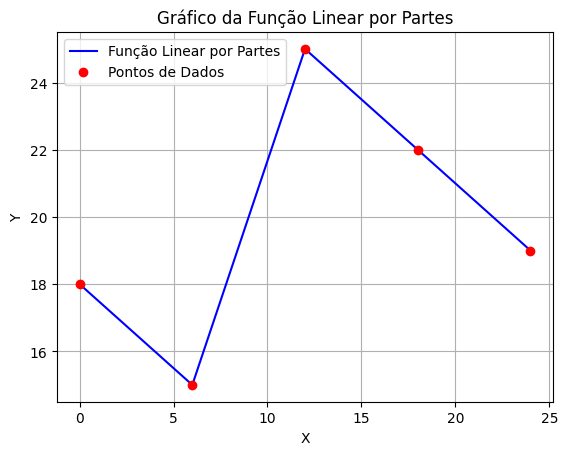

In [54]:
x = [0, 6, 12, 18, 24]
y = [18, 15, 25, 22, 19]

T = linear_interp(x, y)
fig, ax = T.plot()
plt.show()

---

## Exemplo 2:

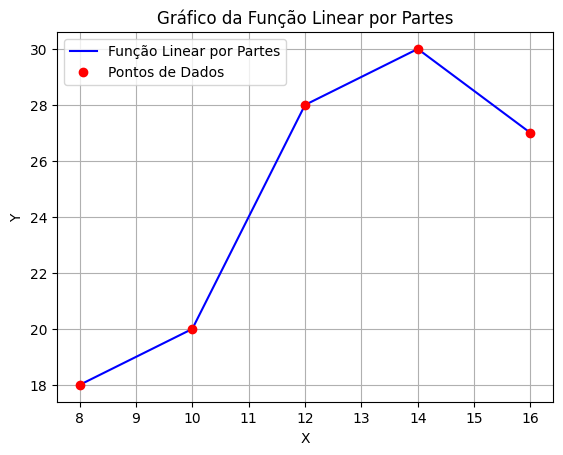

In [55]:
x = [8.0, 10.0, 12.0, 14.0, 16.0]
y = [18.0, 20.0, 28.0, 30.0, 27.0]

interpol = linear_interp(x,y)
fig, ax = interpol.plot()
plt.show()

---

# __Exemplos: Interpolação Polinomial__

## Exemplo 1:

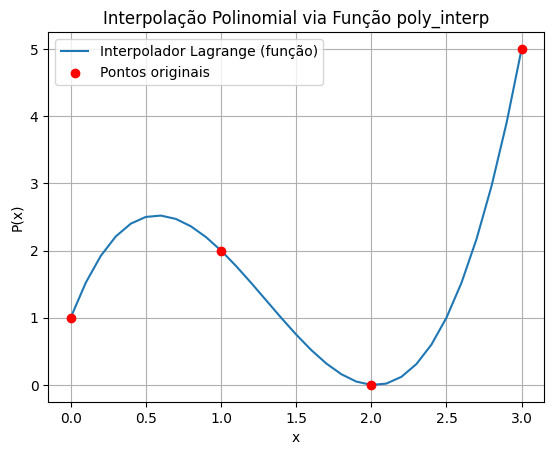

In [56]:
x_poly = [0, 1, 2, 3]
y_poly = [1, 2, 0, 5]


P = poly_interp(x_poly, y_poly)

# SUGESTÃO: TRANSFORMAR O TRECHO ABAIXO EM UMA FUNÇÃO DE PLOTAGEM
X_plot = [i / 10 for i in range(0, 31)]
Y_plot = [P(x) for x in X_plot]

plt.figure()
plt.plot(X_plot, Y_plot, label="Interpolador Lagrange (função)")
plt.scatter(x_poly, y_poly, color="red", zorder=5, label="Pontos originais")
plt.title("Interpolação Polinomial via Função poly_interp")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.grid(True)
plt.legend()
plt.show()


---

## Exemplo 2:

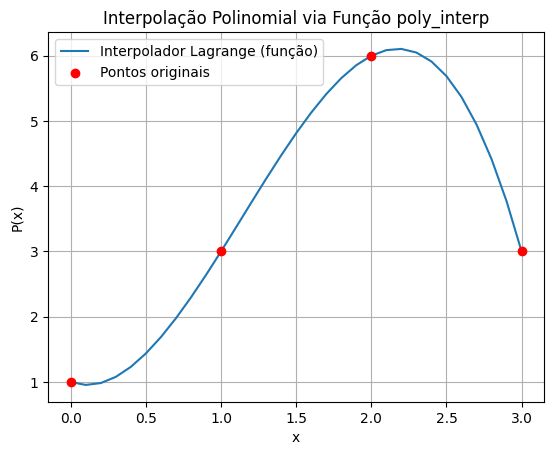

In [57]:
x_poly = [0,1,2,3]
y_poly = [1,3,6,3]

P = poly_interp(x_poly, y_poly)
X_plot = [i / 10 for i in range(0, 31)]  # domínio para visualização
Y_plot = [P(x) for x in X_plot]

# SUGESTÃO: TRANSFORMAR O TRECHO ABAIXO EM UMA FUNÇÃO DE PLOTAGEM
plt.figure()
plt.plot(X_plot, Y_plot, label="Interpolador Lagrange (função)")
plt.scatter(x_poly, y_poly, color="red", zorder=5, label="Pontos originais")
plt.title("Interpolação Polinomial via Função poly_interp")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.grid(True)
plt.legend()
plt.show()


---

# __Exemplo: Interpolador de Hermite__

## Exemplo 1:

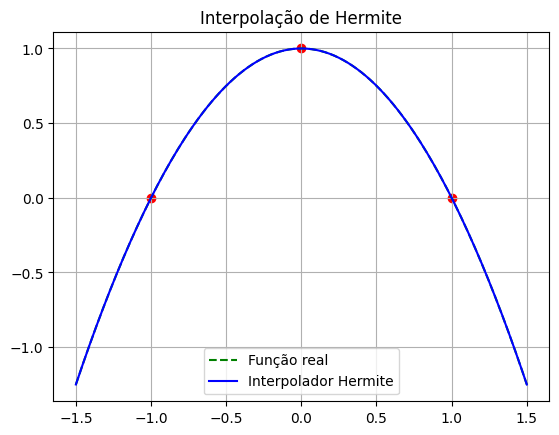

In [58]:
x = [-1, 0, 1]
y = [0, 1, 0]
dy = [-2*x_i for x_i in x]

P = hermite_interp(x, y, dy)
X_plot = np.linspace(-1.5, 1.5, 200)
Y_plot = [P.evaluate(X) for X in X_plot]
Y_real = [1 - X**2 for X in X_plot]

plt.figure()
plt.plot(X_plot, Y_real, 'g--', label="Função real")
plt.plot(X_plot, Y_plot, 'b', label="Interpolador Hermite")
plt.scatter(x, y, color="red")
plt.title("Interpolação de Hermite")
plt.legend()
plt.grid(True)
plt.show()


---

## Exemplo 2

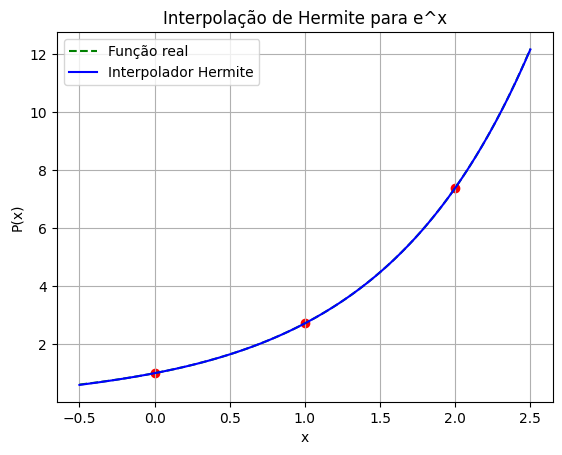

In [59]:
x = [0, 1, 2]
y = [np.exp(xi) for xi in x]
dy = [np.exp(xi) for xi in x]

P = HermiteInterpolation(x, y, dy)
X_plot = np.linspace(-0.5, 2.5, 200)
Y_plot = [P.evaluate(X) for X in X_plot]
Y_real = np.exp(X_plot)

plt.figure()
plt.plot(X_plot, Y_real, 'g--', label="Função real")
plt.plot(X_plot, Y_plot, 'b', label="Interpolador Hermite")
plt.scatter(x, y, color="red")
plt.title("Interpolação de Hermite para e^x")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.legend()
plt.grid(True)
plt.show()


---